# Imports

In [1]:
import os, random, cv2, gc, torch, timm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets
from PIL import Image
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Hyperparameter and Environment Configuration

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_DIR = "/kaggle/input/dr-clean-bengraham-512/train"
VAL_DIR = "/kaggle/input/dr-clean-bengraham-512/val"

BATCH_SIZE = 32
ACCUM_STEPS = 2
EPOCHS = 30
LR = 5e-5
MIN_LR = 3e-6
WEIGHT_DECAY = 5e-4
WARM_UP = 3
PATIENCE = 7


---
# Data Preparation
---

### Data Pipeline & Augmentation

In [3]:
class AlbumentationsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = cv2.imread(path)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            transformed = self.transform(image=sample)
            sample = transformed['image']
            
        return sample, target


train_transform = A.Compose([
    A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
    A.RandomGamma(gamma_limit=(85, 115), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

### Class Balancing Using Weighted Sampler

In [4]:
# Initialize the Dataset
train_dataset = AlbumentationsDataset(TRAIN_DIR, transform=train_transform)
val_dataset = AlbumentationsDataset(VAL_DIR, transform=val_transform)


class_counts = [0] * len(train_dataset.classes)
for _, label in train_dataset.samples:
    class_counts[label] += 1

# The "1/sqrt" magic for balanced Kappa
class_weights = 1.0 / torch.sqrt(torch.tensor(class_counts, dtype=torch.float))
sample_weights = [class_weights[t] for t in train_dataset.targets]

sampler = WeightedRandomSampler(
    weights=sample_weights, 
    num_samples=len(sample_weights), 
    replacement=True
)

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# Val dataset stays standard (Unbalanced for honest testing)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

---
# Model & Training
---

### Model Architecture (CORAL Ordinal Head)

In [5]:
class CoralEffNet(nn.Module):
    def __init__(self, model_name='efficientnetv2_rw_s', num_classes=5):
        super().__init__()
        # Load backbone with higher drop_path_rate to force feature diversity
        self.backbone = timm.create_model(model_name, pretrained=True, drop_path_rate=0.15)
        
        # Increase resolution.
        in_features = self.backbone.get_classifier().in_features
        self.backbone.classifier = nn.Identity()
        
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes - 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.fc(features)

def label_to_ordinal(labels, num_classes=5):
    # Converts label into [1, 1, 0, 0]
    levels = torch.arange(num_classes - 1).to(labels.device)
    return (labels.unsqueeze(1) > levels).float()

def ordinal_to_label(logits):
    probs = torch.sigmoid(logits)
    return (probs > 0.50).sum(dim=1)

### Loss Function & Optimization

In [6]:
model = CoralEffNet().to(DEVICE)
gate_weights = torch.tensor([1.0, 1.1, 1.4, 1.8], device=DEVICE)
criterion = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS - WARM_UP, eta_min=MIN_LR )
scaler = torch.amp.GradScaler() 

model.safetensors:   0%|          | 0.00/96.5M [00:00<?, ?B/s]

### Training Loop with Warmup

In [7]:
best_kappa = -1.0
early_stop_counter = 0  
history = [] 

# START TRAINING 
for epoch in range(EPOCHS):
    if epoch < WARM_UP:
        # Linear Warmup
        curr_lr = LR * (epoch + 1) / WARM_UP
        for param_group in optimizer.param_groups:
            param_group['lr'] = curr_lr
        
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}") 
    
    optimizer.zero_grad()
    for i, (images, labels) in enumerate(pbar):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.amp.autocast(device_type=DEVICE.type):
            outputs = model(images)
            
            targets_ord = label_to_ordinal(labels)
            raw_loss = criterion(outputs, targets_ord)
            weighted_loss = (raw_loss * gate_weights.unsqueeze(0)).mean() 
            loss = weighted_loss / ACCUM_STEPS      

        
        scaler.scale(loss).backward()
        if (i + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
        running_loss += loss.item() * ACCUM_STEPS
        train_preds = ordinal_to_label(outputs)
        correct += (train_preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': f"{running_loss/(i+1):.4f}", 'acc': f"{correct/total:.4f}"})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    # VALIDATION 
    model.eval()
    all_preds, all_labs = [], []
    val_correct, val_total = 0, 0  
    val_running_loss = 0.0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            targets_ord = label_to_ordinal(labels)
            
            with torch.amp.autocast(device_type=DEVICE.type):
                outputs = model(images) 
                
                raw_loss_val = criterion(outputs, targets_ord)
                loss_val = (raw_loss_val * gate_weights.unsqueeze(0)).mean()
                
                val_running_loss += loss_val.item() * images.size(0) 
                val_preds = ordinal_to_label(outputs)
            
            all_preds.extend(val_preds.cpu().numpy())
            all_labs.extend(labels.cpu().numpy())
            val_correct += (val_preds == labels).sum().item()  
            val_total += labels.size(0)

             
    
    # Calculate Final Metrics for the Epoch
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    bal_acc = balanced_accuracy_score(all_labs, all_preds)
    val_kappa = cohen_kappa_score(all_labs, all_preds, weights='quadratic')

    # history 
    history.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss,
        'val_loss': val_loss,
        'train_acc': epoch_acc,
        'val_acc': val_acc,  
        'val_kappa': val_kappa,
        'val_bal_acc': bal_acc
    })
    
    print(f"\nEPOCH {epoch+1}: Train Loss {epoch_loss:.4f} | Val Loss {val_loss:.4f}")
    print(f"Train Acc {epoch_acc:.4f} | Val Acc {val_acc:.4f} | Gap: {epoch_acc-val_acc:.4f}") 
    print(f"Balanced Val Acc: {bal_acc:.4f} | Kappa: {val_kappa:.4f}")

    # Recall check
    report = classification_report(
        all_labs, 
        all_preds, 
        target_names=train_dataset.classes, 
        output_dict=True, 
        zero_division=0
    )

    # Clean print for the console
    recall_str = " | ".join([f"C{k} Rec: {report[str(k)]['recall']:.3f}" for k in range(5)])
    print(f"Recall per Class: {recall_str}")
    
    # Learning rate optimize
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.2e}")
    
    # Saving Best Kappa
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        torch.save(model.state_dict(), "best_DR_model.pth")
        print(f"New Best Kappa! Saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"No improvement. Patience: {early_stop_counter}/{PATIENCE}")

    # Early stop
    if early_stop_counter >= PATIENCE:
        print(f"Early Stopping triggered at Epoch {epoch+1}")
        break

    if epoch >= WARM_UP:
        scheduler.step()
        if epoch == WARM_UP:
            scheduler.last_epoch = 0
        
    gc.collect()
    torch.cuda.empty_cache()

Epoch 1/30: 100%|██████████| 452/452 [06:59<00:00,  1.08it/s, loss=0.6769, acc=0.2015]



EPOCH 1: Train Loss 0.6769 | Val Loss 0.4840
Train Acc 0.2015 | Val Acc 0.0915 | Gap: 0.1100
Balanced Val Acc: 0.2968 | Kappa: 0.2003
Recall per Class: C0 Rec: 0.000 | C1 Rec: 0.971 | C2 Rec: 0.102 | C3 Rec: 0.051 | C4 Rec: 0.359
Current LR: 1.67e-05
New Best Kappa! Saved.


Epoch 2/30: 100%|██████████| 452/452 [06:56<00:00,  1.08it/s, loss=0.4821, acc=0.3781]



EPOCH 2: Train Loss 0.4821 | Val Loss 0.3423
Train Acc 0.3781 | Val Acc 0.5562 | Gap: -0.1781
Balanced Val Acc: 0.4590 | Kappa: 0.5690
Recall per Class: C0 Rec: 0.612 | C1 Rec: 0.358 | C2 Rec: 0.403 | C3 Rec: 0.514 | C4 Rec: 0.408
Current LR: 3.33e-05
New Best Kappa! Saved.


Epoch 3/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.3833, acc=0.5086]



EPOCH 3: Train Loss 0.3833 | Val Loss 0.3147
Train Acc 0.5086 | Val Acc 0.5528 | Gap: -0.0442
Balanced Val Acc: 0.5178 | Kappa: 0.6104
Recall per Class: C0 Rec: 0.580 | C1 Rec: 0.448 | C2 Rec: 0.474 | C3 Rec: 0.531 | C4 Rec: 0.556
Current LR: 5.00e-05
New Best Kappa! Saved.


Epoch 4/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.3423, acc=0.5594]



EPOCH 4: Train Loss 0.3423 | Val Loss 0.2775
Train Acc 0.5594 | Val Acc 0.6484 | Gap: -0.0890
Balanced Val Acc: 0.5227 | Kappa: 0.6731
Recall per Class: C0 Rec: 0.721 | C1 Rec: 0.313 | C2 Rec: 0.479 | C3 Rec: 0.509 | C4 Rec: 0.592
Current LR: 5.00e-05
New Best Kappa! Saved.


Epoch 5/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.3172, acc=0.5849]



EPOCH 5: Train Loss 0.3172 | Val Loss 0.2633
Train Acc 0.5849 | Val Acc 0.6812 | Gap: -0.0963
Balanced Val Acc: 0.5362 | Kappa: 0.6986
Recall per Class: C0 Rec: 0.768 | C1 Rec: 0.280 | C2 Rec: 0.473 | C3 Rec: 0.583 | C4 Rec: 0.577
Current LR: 4.98e-05
New Best Kappa! Saved.


Epoch 6/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2931, acc=0.6122]



EPOCH 6: Train Loss 0.2931 | Val Loss 0.2757
Train Acc 0.6122 | Val Acc 0.6635 | Gap: -0.0513
Balanced Val Acc: 0.5708 | Kappa: 0.6882
Recall per Class: C0 Rec: 0.732 | C1 Rec: 0.323 | C2 Rec: 0.491 | C3 Rec: 0.646 | C4 Rec: 0.662
Current LR: 4.97e-05
No improvement. Patience: 1/7


Epoch 7/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2798, acc=0.6264]



EPOCH 7: Train Loss 0.2798 | Val Loss 0.3027
Train Acc 0.6264 | Val Acc 0.6086 | Gap: 0.0178
Balanced Val Acc: 0.5530 | Kappa: 0.6460
Recall per Class: C0 Rec: 0.634 | C1 Rec: 0.335 | C2 Rec: 0.615 | C3 Rec: 0.589 | C4 Rec: 0.592
Current LR: 4.92e-05
No improvement. Patience: 2/7


Epoch 8/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2583, acc=0.6588]



EPOCH 8: Train Loss 0.2583 | Val Loss 0.2920
Train Acc 0.6588 | Val Acc 0.6223 | Gap: 0.0365
Balanced Val Acc: 0.5661 | Kappa: 0.6675
Recall per Class: C0 Rec: 0.652 | C1 Rec: 0.391 | C2 Rec: 0.591 | C3 Rec: 0.577 | C4 Rec: 0.620
Current LR: 4.84e-05
No improvement. Patience: 3/7


Epoch 9/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2416, acc=0.6696]



EPOCH 9: Train Loss 0.2416 | Val Loss 0.2488
Train Acc 0.6696 | Val Acc 0.7168 | Gap: -0.0472
Balanced Val Acc: 0.5672 | Kappa: 0.7288
Recall per Class: C0 Rec: 0.799 | C1 Rec: 0.301 | C2 Rec: 0.543 | C3 Rec: 0.594 | C4 Rec: 0.599
Current LR: 4.73e-05
New Best Kappa! Saved.


Epoch 10/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2337, acc=0.6844]



EPOCH 10: Train Loss 0.2337 | Val Loss 0.2540
Train Acc 0.6844 | Val Acc 0.7055 | Gap: -0.0211
Balanced Val Acc: 0.5672 | Kappa: 0.7220
Recall per Class: C0 Rec: 0.774 | C1 Rec: 0.356 | C2 Rec: 0.578 | C3 Rec: 0.537 | C4 Rec: 0.592
Current LR: 4.60e-05
No improvement. Patience: 1/7


Epoch 11/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2186, acc=0.6965]



EPOCH 11: Train Loss 0.2186 | Val Loss 0.2687
Train Acc 0.6965 | Val Acc 0.6966 | Gap: -0.0000
Balanced Val Acc: 0.5649 | Kappa: 0.7088
Recall per Class: C0 Rec: 0.751 | C1 Rec: 0.354 | C2 Rec: 0.632 | C3 Rec: 0.566 | C4 Rec: 0.521
Current LR: 4.44e-05
No improvement. Patience: 2/7


Epoch 12/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.2097, acc=0.7108]



EPOCH 12: Train Loss 0.2097 | Val Loss 0.2588
Train Acc 0.7108 | Val Acc 0.7249 | Gap: -0.0140
Balanced Val Acc: 0.5682 | Kappa: 0.7279
Recall per Class: C0 Rec: 0.805 | C1 Rec: 0.301 | C2 Rec: 0.574 | C3 Rec: 0.577 | C4 Rec: 0.585
Current LR: 4.25e-05
No improvement. Patience: 3/7


Epoch 13/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.1989, acc=0.7219]



EPOCH 13: Train Loss 0.1989 | Val Loss 0.2754
Train Acc 0.7219 | Val Acc 0.6971 | Gap: 0.0248
Balanced Val Acc: 0.5797 | Kappa: 0.7107
Recall per Class: C0 Rec: 0.758 | C1 Rec: 0.319 | C2 Rec: 0.600 | C3 Rec: 0.623 | C4 Rec: 0.599
Current LR: 4.04e-05
No improvement. Patience: 4/7


Epoch 14/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.1922, acc=0.7329]



EPOCH 14: Train Loss 0.1922 | Val Loss 0.2590
Train Acc 0.7329 | Val Acc 0.7052 | Gap: 0.0277
Balanced Val Acc: 0.5664 | Kappa: 0.7187
Recall per Class: C0 Rec: 0.773 | C1 Rec: 0.352 | C2 Rec: 0.581 | C3 Rec: 0.577 | C4 Rec: 0.549
Current LR: 3.81e-05
No improvement. Patience: 5/7


Epoch 15/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.1812, acc=0.7446]



EPOCH 15: Train Loss 0.1812 | Val Loss 0.2951
Train Acc 0.7446 | Val Acc 0.6684 | Gap: 0.0762
Balanced Val Acc: 0.5726 | Kappa: 0.6905
Recall per Class: C0 Rec: 0.713 | C1 Rec: 0.354 | C2 Rec: 0.619 | C3 Rec: 0.571 | C4 Rec: 0.606
Current LR: 3.57e-05
No improvement. Patience: 6/7


Epoch 16/30: 100%|██████████| 452/452 [06:57<00:00,  1.08it/s, loss=0.1761, acc=0.7556]



EPOCH 16: Train Loss 0.1761 | Val Loss 0.2800
Train Acc 0.7556 | Val Acc 0.6856 | Gap: 0.0700
Balanced Val Acc: 0.5532 | Kappa: 0.7010
Recall per Class: C0 Rec: 0.744 | C1 Rec: 0.376 | C2 Rec: 0.594 | C3 Rec: 0.531 | C4 Rec: 0.521
Current LR: 3.31e-05
No improvement. Patience: 7/7
Early Stopping triggered at Epoch 16


---
# Model Evaluations
---

### Unoptimized Threshold Model Evaluation

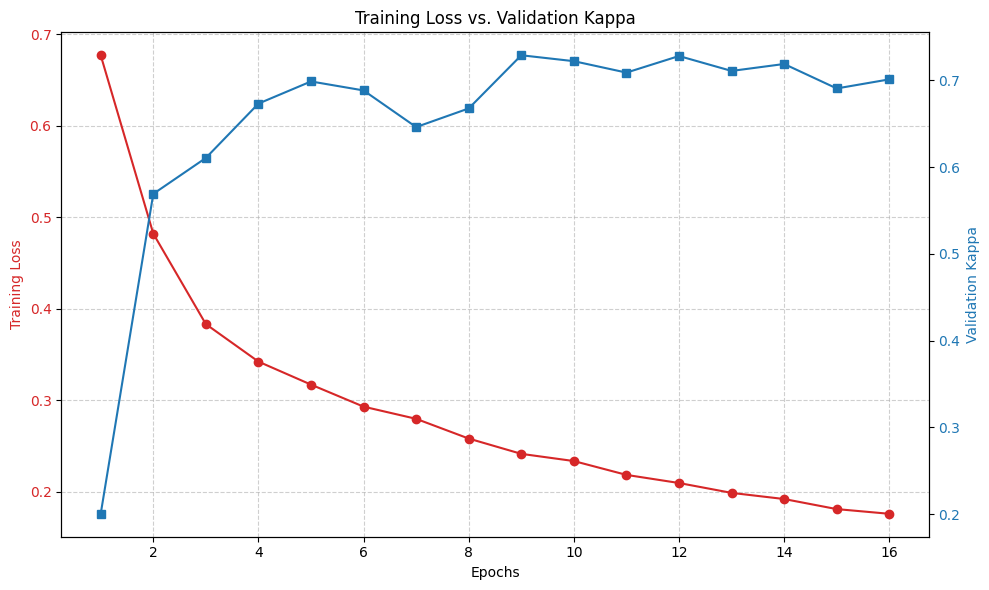

In [8]:
def plot_training_results(history):
    epochs = range(1, len(history) + 1)
    train_loss = [h['train_loss'] for h in history]
    val_kappa = [h['val_kappa'] for h in history]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss 
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(epochs, train_loss, color=color, marker='o', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot Kappa on the same chart (Secondary Axis) 
    ax2 = ax1.twinx() 
    color = 'tab:blue'
    ax2.set_ylabel('Validation Kappa', color=color)
    ax2.plot(epochs, val_kappa, color=color, marker='s', label='Val Kappa')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Training Loss vs. Validation Kappa')
    fig.tight_layout()
    plt.savefig('learning_curves.png')
    plt.show()

plot_training_results(history)

In [9]:
def final_evaluation(model, val_loader, device, thresholds=None):
    model.load_state_dict(torch.load("best_DR_model.pth"))
    model.eval()
    
    all_preds, all_labs = [], []
    all_logits = []

    # Collect Logits/Probs
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Final Evaluation"):
            images = images.to(device)
            with torch.amp.autocast(device_type=DEVICE.type):
                logits = model(images)
                # We work with Sigmoid for ordinal regression
                probs = torch.sigmoid(logits)
                
            all_logits.append(probs.cpu())
            all_labs.extend(labels.cpu().numpy())
    
    all_logits = torch.cat(all_logits, dim=0)
    
    # Decision Logic (Standard vs Optimized)
    if thresholds is None:
        print("\nRUNNING RAW EVALUATION (Standard 0.5 Thresholds)... ")
        # Standard ordinal_to_label logic
        all_preds = (all_logits > 0.5).sum(axis=1).numpy()
    else:
        print(f"\nRUNNING OPTIMIZED EVALUATION (Custom Thresholds)... ")
        print(f"Thresholds: {[round(t, 4) for t in thresholds]}")
        # Optimized 
        all_preds = (all_logits > torch.tensor(thresholds)).sum(axis=1).numpy()

    # Metrics & Reporting
    classes = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"]
    
    # Metrics
    acc = accuracy_score(all_labs, all_preds)
    bal_acc = balanced_accuracy_score(all_labs, all_preds)
    kappa = cohen_kappa_score(all_labs, all_preds, weights='quadratic')
    
    print("\nDetailed Classification Report:")
    print(classification_report(all_labs, all_preds, target_names=classes, zero_division=0))

    print(f"Overall Accuracy:   {acc:.4f}")
    print(f"Balanced Accuracy:  {bal_acc:.4f}")
    print(f"Quadratic Kappa:    {kappa:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labs, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix (Kappa: {kappa:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Final Evaluation: 100%|██████████| 220/220 [00:51<00:00,  4.25it/s]



RUNNING RAW EVALUATION (Standard 0.5 Thresholds)... 

Detailed Classification Report:
               precision    recall  f1-score   support

        No DR       0.90      0.80      0.85      5162
         Mild       0.13      0.30      0.18       489
     Moderate       0.59      0.54      0.57      1058
       Severe       0.39      0.59      0.47       175
Proliferative       0.73      0.60      0.66       142

     accuracy                           0.72      7026
    macro avg       0.55      0.57      0.55      7026
 weighted avg       0.79      0.72      0.75      7026

Overall Accuracy:   0.7168
Balanced Accuracy:  0.5672
Quadratic Kappa:    0.7288


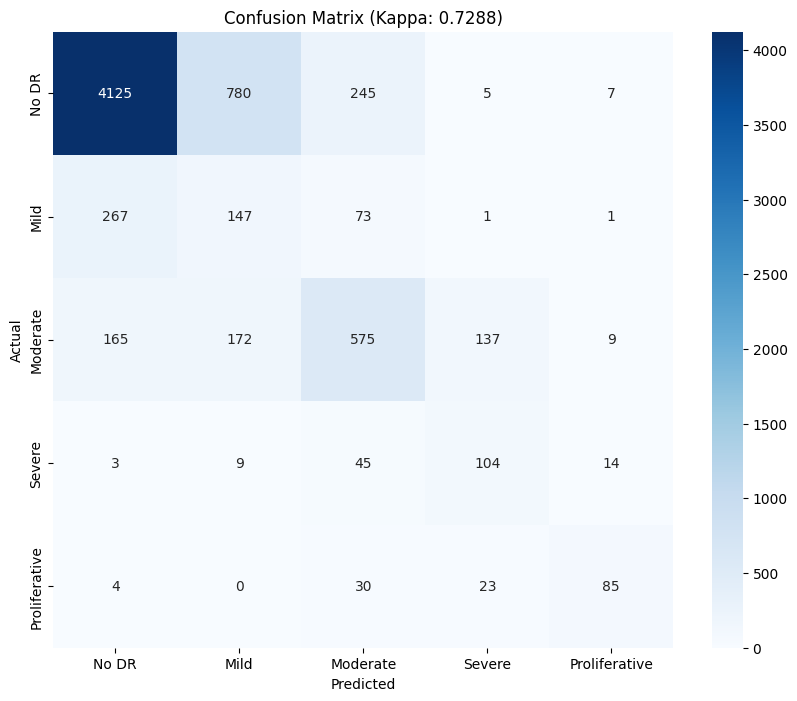

In [10]:
final_evaluation(model, val_loader, DEVICE, thresholds=None)

### Model Threshold Optimization 

In [11]:
from scipy.optimize import minimize

def optimize_thresholds(model, val_loader, device):
    model.eval()
    all_logits = []
    all_targets = []

    print("Extracting Logits for Calibration...")
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            with torch.amp.autocast('cuda'):
                logits = model(images.to(device))
            all_logits.append(logits.cpu().numpy())
            all_targets.append(labels.numpy())

    all_logits = np.concatenate(all_logits)
    all_targets = np.concatenate(all_targets)

    # The Objective: Maximize Kappa (Minimize -Kappa)
    def kappa_objective(thresholds):
        probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
        preds = (probs > thresholds).sum(axis=1)
        # return negative. "minimize" looks for the lowest value
        return -cohen_kappa_score(all_targets, preds, weights='quadratic')

    print("Searching for Optimal Thresholds...")
    initial_thresholds = [0.5, 0.5, 0.5, 0.5]
    res = minimize(kappa_objective, initial_thresholds, method='Nelder-Mead')
    
    best_thresholds = res.x
    best_kappa = -res.fun
    
    print("\n" + "="*40)
    print(f"Base Kappa (0.5): {-kappa_objective([0.5]*4):.4f}")
    print(f"Optimized Kappa:  {best_kappa:.4f}")
    print(f"Best Thresholds:  {best_thresholds}")
    print("="*40)
    
    return best_thresholds

### Optimized Threshold Model Evaluation

Extracting Logits for Calibration...


100%|██████████| 220/220 [00:51<00:00,  4.24it/s]
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: Runt

Searching for Optimal Thresholds...


/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 1 / (1 + np.exp(-all_logits)) # Sigmoid
/tmp/ipykernel_24/3831793831.py:21: RuntimeWarning: overflow encountered in exp
  probs = 


Base Kappa (0.5): 0.7288
Optimized Kappa:  0.7598
Best Thresholds:  [0.68955151 0.67242238 0.30901286 0.37269038]


Final Evaluation: 100%|██████████| 220/220 [00:51<00:00,  4.24it/s]



RUNNING OPTIMIZED EVALUATION (Custom Thresholds)... 
Thresholds: [np.float64(0.6896), np.float64(0.6724), np.float64(0.309), np.float64(0.3727)]

Detailed Classification Report:
               precision    recall  f1-score   support

        No DR       0.88      0.92      0.90      5162
         Mild       0.16      0.19      0.17       489
     Moderate       0.69      0.38      0.49      1058
       Severe       0.32      0.66      0.43       175
Proliferative       0.68      0.63      0.65       142

     accuracy                           0.77      7026
    macro avg       0.55      0.56      0.53      7026
 weighted avg       0.79      0.77      0.77      7026

Overall Accuracy:   0.7738
Balanced Accuracy:  0.5553
Quadratic Kappa:    0.7598


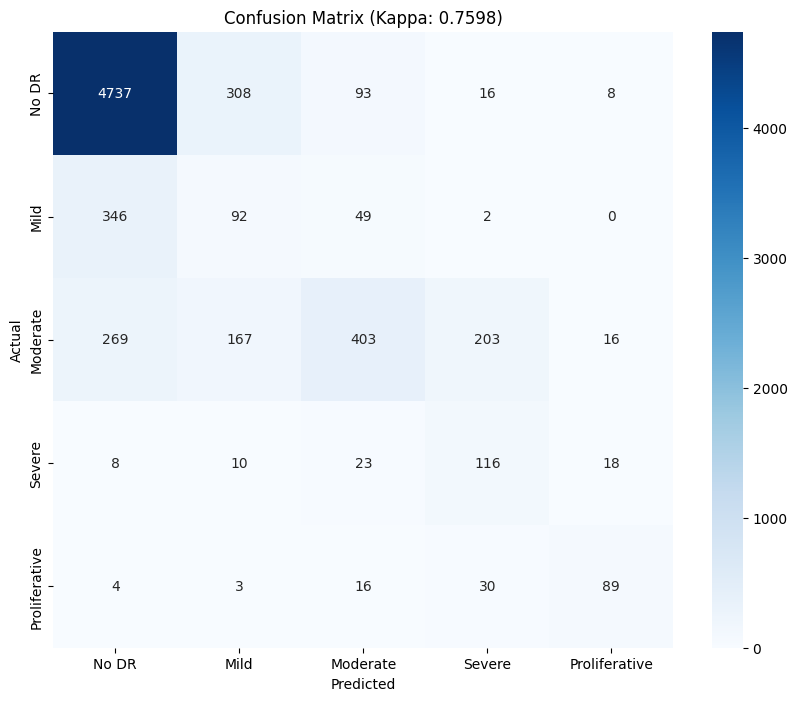

In [12]:
best_thresholds = optimize_thresholds(model, val_loader, DEVICE)
final_evaluation(model, val_loader, DEVICE, thresholds=best_thresholds)

# Grad Cam

In [13]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

def plot_gradcam_effnet(img_path, actual_label, model, transform, thresholds):
    model.eval()
    
    # 1. Preprocess
    img_pil = Image.open(img_path).convert('RGB')
    img_np_orig = np.array(img_pil)
    img_resized = cv2.resize(img_np_orig, (512, 512))
    input_tensor = transform(image=img_resized)['image'].unsqueeze(0).to(DEVICE)
    
    # 2. Get Prediction using thresholds
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.sigmoid(logits)
        thresh_tensor = torch.tensor(thresholds).to(DEVICE)
        pred = (probs > thresh_tensor).sum(dim=1).item()
    
    # 3. Determine target gate
    target_idx = max(0, min(3, pred - 1)) if pred > 0 else 0
    
    # 4. Target Layer for EfficientNetV2 (timm)
    # conv_head is the final spatial feature map before pooling
    target_layers = [model.backbone.conv_head] 
    
    with GradCAM(model=model, target_layers=target_layers) as cam:
        targets = [ClassifierOutputTarget(target_idx)]
        grayscale_cam = cam(input_tensor=input_tensor, 
                            targets=targets,
                            aug_smooth=True, 
                            eigen_smooth=True)[0, :]
        
        visualization = show_cam_on_image(img_resized/255.0, grayscale_cam, use_rgb=True)
        
    # 5. Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title(f"Actual: {actual_label}\n(EffNet Input)", fontsize=10)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"EffNet Pred: Stage {pred}\n(Gate {target_idx})", fontsize=10, color='blue')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


model = CoralEffNet().to(DEVICE)
model.load_state_dict(torch.load("best_DR_model.pth"))

class_samples = {}

for path, label in val_dataset.samples:
    if label not in class_samples:
        class_samples[label] = path
     # Stop once we have 0, 1, 2, 3, and 4
    if len(class_samples) == 5:
        break


for label in sorted(class_samples.keys()):
    img_path = class_samples[label]
    print(f"\nEfficientNet Audit: Class {label}")
    plot_gradcam_effnet(img_path, label, model, val_transform)


EfficientNet Audit: Class 0


TypeError: plot_gradcam_effnet() missing 1 required positional argument: 'thresholds'

In [ ]:
# 1. Unoptimized Run
print("EffNet Audit: Standard 0.5 Thresholds")
standard_thresholds = [0.5, 0.5, 0.5, 0.5]
for label in sorted(class_samples.keys()):
    img_path = class_samples[label]
    print(f"\nEfficientNet Audit: Class {label}")
    plot_gradcam_effnet(img_path, label, model, val_transform, standard_thresholds)


In [ ]:

# 2. Optimized Run
print(f"EffNet Audit: Optimized Thresholds {best_thresholds} ")
for label in sorted(class_samples.keys()):
    img_path = class_samples[label]
    print(f"\nEfficientNet Audit: Class {label}")
    plot_gradcam_effnet(class_samples[label], label, model, val_transform, best_thresholds)
